In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
conda install -c conda-forge albumentations

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - albumentations


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    albumentations-1.2.1       |     pyhd8ed1ab_0          86 KB  conda-forge
    alsa-lib-1.2.3.2           |       h166bdaf_0         554 KB  conda-forge
    blosc-1.21.1               |       hd32f23e_0         955 KB  conda-forge
    brotli-1.0.9               |       h166bdaf_7          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_7          19 KB  conda-forge
    brunsli-0.1                |       h9c3ff4c_0         200 KB  conda-forge
    c-blosc2-2.0.4             |       h5f21a17_1         183 KB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  co

In [3]:
# Download Libraries 
!pip install rasterio
!pip install Shapely==1.8.1.post1
!pip install scikit-image
!pip install -U efficientnet_pytorch
!pip install pytorch-metric-learning
!pip install -q timm
!pip install tqdm
!pip install ipywidgets 
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 20.7 MB 3.0 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.1 MB 3.0 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b336610ee2e6d7c5471f6eecf3d634b4ad2fbcbf0766ef14cddcfeaa80d986e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-a6azk_7o/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 110 kB 3.2 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in in

In [2]:
from model.resnet import *
from model.effnet import *
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import torch
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [3]:
# Check file or directory is exist
train_df = pd.read_csv('../../dataset/ForestNetDataset /train.csv')
val_df = pd.read_csv('../../dataset/ForestNetDataset /val.csv')
test_df = pd.read_csv('../../dataset/ForestNetDataset /test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.7202663845775041_115.00699582064483
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.02237632340159


(1, 332, 332)


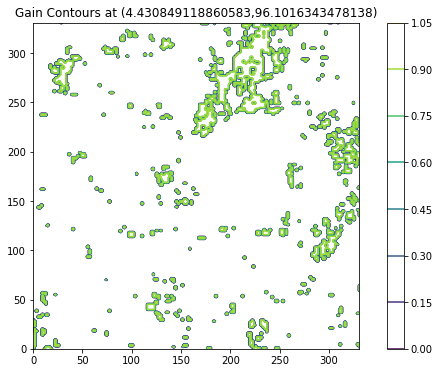

In [4]:
data_array = np.load('../../dataset/ForestNetDataset /examples/4.430849118860583_96.1016343478138/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (4.430849118860583,96.1016343478138)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

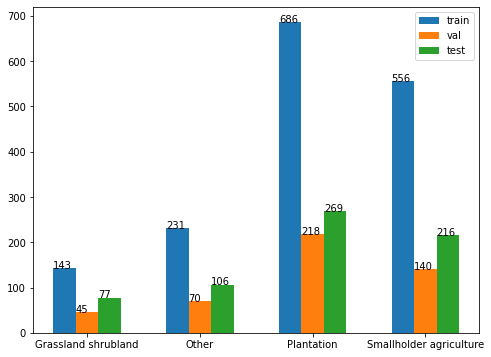

In [5]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [6]:
class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir='../../dataset/ForestNetDataset ', transform=None, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        self.types = types

    def __len__(self):
        return len(self.csv)
    
    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        
        ## Load the image and auxiliary
        image = io.imread(f'{self.root_dir}/{folder}/images/visible/composite.png')
        slope = np.load(f'{self.root_dir}/{folder}/auxiliary/slope.npy')
          
        ## Get the segmentation map
        with open(f'{self.root_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)
      
        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)
              
        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
          
        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, slope, merged_label
        else:
            return image, merged_label
 

In [7]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [8]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [9]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df)
test_dataset = ForestDataset(csv_file_to_df=test_df)  
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [10]:
dataiter = iter(trainloader)
images, slope, labels = dataiter.next()

print('images shape on PyTroch : ', images.size())
print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
slope shape on PyTroch :  torch.Size([16, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [12]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [13]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

## Multimodal SuperCon using Custom Resnet as Backbone

In [14]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        for phase in ['train','val']:
            if(phase == 'train'):
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            # deep copy the model
            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
"""Training Projection Head"""

pretrained_resnet_18 = timm.create_model('resnet18', pretrained=True)
num_ftrs = pretrained_resnet_18.get_classifier().in_features
pretrained_resnet_18.fc = nn.Linear(num_ftrs, 4)
pretrained_resnet_18 = pretrained_resnet_18.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(pretrained_resnet_18.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(pretrained_resnet_18, criterion, optimizer, scheduler, 20, dataloaders_re)


Epoch 1/20
----------
train Loss: 0.8429
val Loss: 0.6841
Epoch 2/20
----------
train Loss: 0.8343
val Loss: 0.6437
Epoch 3/20
----------
train Loss: 0.8373
val Loss: 0.6491
Epoch 4/20
----------


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.9341
val Loss: 0.6783
Epoch 5/20
----------
train Loss: 0.9256
val Loss: 0.7011
Epoch 6/20
----------
train Loss: 0.9229
val Loss: 0.6432
Epoch 7/20
----------
train Loss: 0.9260
val Loss: 0.7235
Epoch 8/20
----------
train Loss: 0.9349
val Loss: 0.6742
Epoch 9/20
----------
train Loss: 0.9216
val Loss: 0.6703
Epoch 10/20
----------
train Loss: 0.9507
val Loss: 0.6540
Epoch 11/20
----------
train Loss: 0.9401
val Loss: 0.6977
Epoch 12/20
----------
train Loss: 0.9144
val Loss: 0.6758
Epoch 13/20
----------
train Loss: 0.9041
val Loss: 0.6878
Epoch 14/20
----------
train Loss: 0.9218
val Loss: 0.6601
Epoch 15/20
----------
train Loss: 0.9107
val Loss: 0.6482
Epoch 16/20
----------
train Loss: 0.9031
val Loss: 0.6726
Epoch 17/20
----------
train Loss: 0.8943
val Loss: 0.6832
Epoch 18/20
----------
train Loss: 0.8802
val Loss: 0.6565
Epoch 19/20
----------
train Loss: 0.9269
val Loss: 0.7033
Epoch 20/20
----------
train Loss: 0.9367
val Loss: 0.7320
Training complete in 0h 1

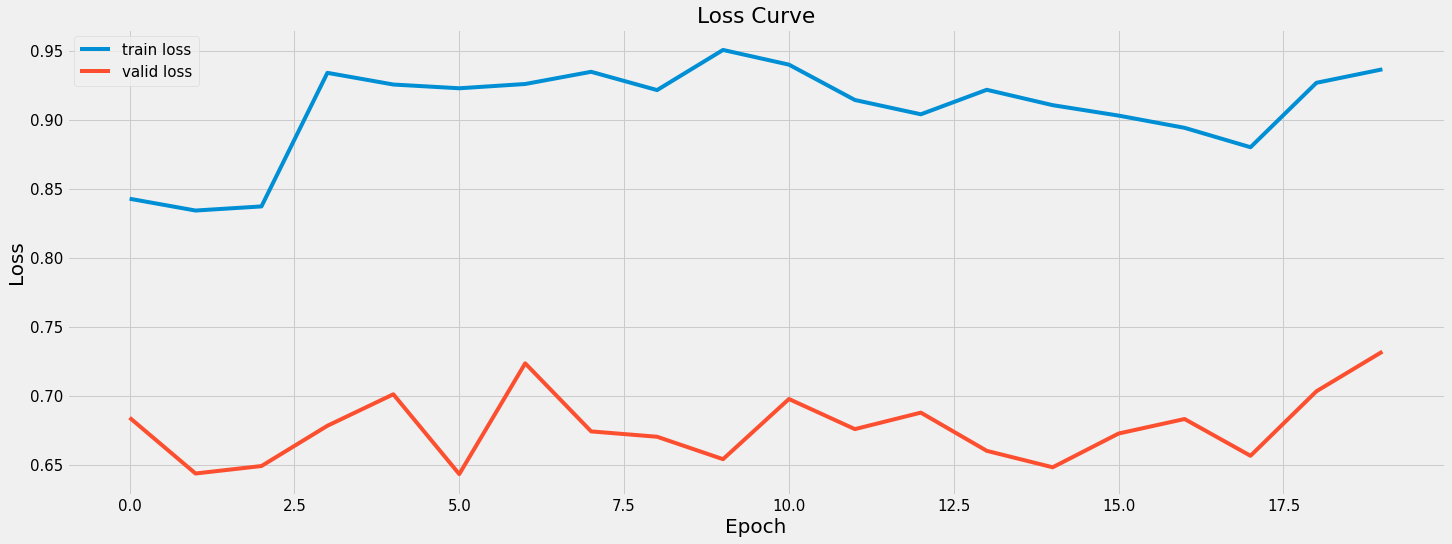

In [16]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"
fig = plt.figure(figsize=(22,8))
epochs = list(range(20))

plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

In [17]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for images, slope, labels in dataloaders[phase]:
                images = images.to(device)
                slope = slope.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, slope).to(device)
                    _, preds = torch.max(outputs, 1)
                    preds.to(device)
                    loss = criterion(outputs.to(device), labels.to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_dict[phase].append(epoch_acc)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curves(acc_dict, loss_dict)
    model.load_state_dict(best_model_wts)
    return model

Epoch 1/15
----------
train Loss: 0.6323 Acc: 0.4604
val Loss: 0.4801 Acc: 0.5011
Epoch 2/15
----------
train Loss: 0.5519 Acc: 0.4635
val Loss: 0.4281 Acc: 0.5370
Epoch 3/15
----------
train Loss: 0.4536 Acc: 0.5161
val Loss: 0.4523 Acc: 0.5011
Epoch 4/15
----------
train Loss: 0.3994 Acc: 0.5415
val Loss: 0.5192 Acc: 0.5095
Epoch 5/15
----------
train Loss: 0.3266 Acc: 0.6244
val Loss: 0.4732 Acc: 0.5285
Epoch 6/15
----------
train Loss: 0.2711 Acc: 0.6417
val Loss: 0.6692 Acc: 0.3214
Epoch 7/15
----------
train Loss: 0.2439 Acc: 0.6528
val Loss: 0.4607 Acc: 0.5032
Epoch 8/15
----------
train Loss: 0.1616 Acc: 0.7314
val Loss: 0.5730 Acc: 0.4841
Epoch 9/15
----------
train Loss: 0.1525 Acc: 0.7364
val Loss: 0.5597 Acc: 0.5201
Epoch 10/15
----------
train Loss: 0.1529 Acc: 0.7358
val Loss: 0.5996 Acc: 0.5159
Epoch 11/15
----------
train Loss: 0.1478 Acc: 0.7401
val Loss: 0.6986 Acc: 0.5116
Epoch 12/15
----------
train Loss: 0.1294 Acc: 0.7593
val Loss: 0.7504 Acc: 0.5180
Epoch 13/15
-

<Figure size 1584x576 with 0 Axes>

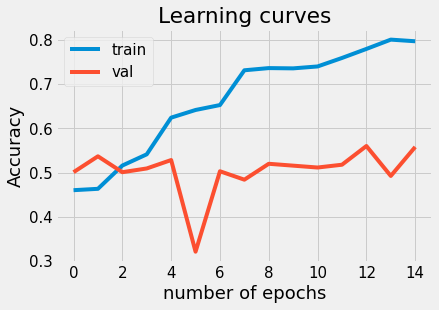

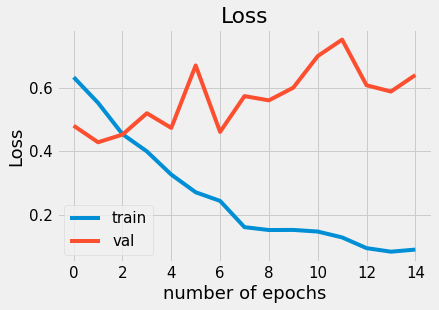

In [18]:
"""Training Resnet Classifier"""

resnet_classifier = resnet18(pretrained=False) 

num_ftrs = resnet_classifier.fc.in_features
resnet_classifier.fc = nn.Linear(
    in_features = num_ftrs, 
    out_features = nbClass
)

resnet_classifier = resnet_classifier.to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(resnet_classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

resnet_classifier = train_model(resnet_classifier, criterion, optimizer, scheduler, num_epochs=15)

In [25]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, slope, labels in testloader: 
            images = images.to(device)
            slope = slope.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            outputs = model(images, slope).to(device)
            _, preds = torch.max(outputs, 1)
            preds.to(device)

            total += labels.size(0) 
            running_accuracy += (preds == labels).sum()
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / total))  

In [20]:
test(resnet_classifier)

Accuracy of the model based on the test set is: 50 %


## Multimodal SuperCon using Custom Efficientnet as Backbone

In [21]:
"""Training Projection Head"""
from collections import defaultdict
from time import time

pretrained_eff_b1 = timm.create_model('efficientnet_b2', pretrained=True)
num_ftrs = pretrained_eff_b1.get_classifier().in_features
pretrained_eff_b1.fc = nn.Linear(num_ftrs, 4)
pretrained_eff_b1 = pretrained_eff_b1.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(pretrained_eff_b1.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model, history = train_model_SCL(pretrained_eff_b1, criterion, optimizer, scheduler, 20, dataloaders_re)

Epoch 1/20
----------
train Loss: 0.7364
val Loss: 0.6441
Epoch 2/20
----------
train Loss: 0.7033
val Loss: 0.6431
Epoch 3/20
----------
train Loss: 0.7250
val Loss: 0.6363
Epoch 4/20
----------


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5815
val Loss: 0.5408
Epoch 5/20
----------
train Loss: 0.5746
val Loss: 0.5437
Epoch 6/20
----------
train Loss: 0.5727
val Loss: 0.5417
Epoch 7/20
----------
train Loss: 0.5757
val Loss: 0.5425
Epoch 8/20
----------
train Loss: 0.5708
val Loss: 0.5430
Epoch 9/20
----------
train Loss: 0.5717
val Loss: 0.5412
Epoch 10/20
----------
train Loss: 0.5750
val Loss: 0.5417
Epoch 11/20
----------
train Loss: 0.5640
val Loss: 0.5421
Epoch 12/20
----------
train Loss: 0.5699
val Loss: 0.5409
Epoch 13/20
----------
train Loss: 0.5695
val Loss: 0.5418
Epoch 14/20
----------
train Loss: 0.5747
val Loss: 0.5413
Epoch 15/20
----------
train Loss: 0.5782
val Loss: 0.5407
Epoch 16/20
----------
train Loss: 0.5585
val Loss: 0.5407
Epoch 17/20
----------
train Loss: 0.5633
val Loss: 0.5422
Epoch 18/20
----------
train Loss: 0.5711
val Loss: 0.5398
Epoch 19/20
----------
train Loss: 0.5722
val Loss: 0.5412
Epoch 20/20
----------
train Loss: 0.5665
val Loss: 0.5422
Training complete in 0h 1

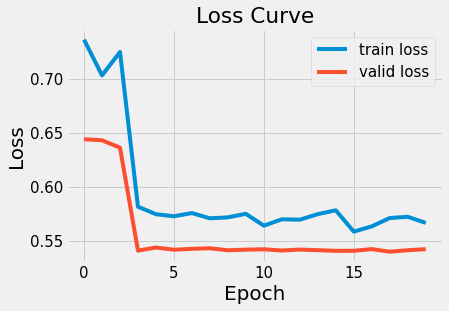

In [22]:
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2
Epoch 1/15
----------
train Loss: 0.4237 Acc: 0.5897
val Loss: 0.2846 Acc: 0.7188
Epoch 2/15
----------
train Loss: 0.2443 Acc: 0.6838
val Loss: 0.3637 Acc: 0.7590
Epoch 3/15
----------
train Loss: 0.2120 Acc: 0.7067
val Loss: 0.2547 Acc: 0.7674
Epoch 4/15
----------
train Loss: 0.2260 Acc: 0.6931
val Loss: 0.1450 Acc: 0.7484
Epoch 5/15
----------
train Loss: 0.1789 Acc: 0.7228
val Loss: 0.3193 Acc: 0.6808
Epoch 6/15
----------
train Loss: 0.2132 Acc: 0.7061
val Loss: 0.2328 Acc: 0.6829
Epoch 7/15
----------
train Loss: 0.1736 Acc: 0.7407
val Loss: 0.2797 Acc: 0.6934
Epoch 8/15
----------
train Loss: 0.1382 Acc: 0.7611
val Loss: 0.2876 Acc: 0.7463
Epoch 9/15
----------
train Loss: 0.1195 Acc: 0.7679
val Loss: 0.1529 Acc: 0.7400
Epoch 10/15
----------
train Loss: 0.0751 Acc: 0.8317
val Loss: 0.1455 Acc: 0.7759
Epoch 11/15
----------
train Loss: 0.0848 Acc: 0.8267
val Loss: 0.2042 Acc: 0.7273
Epoch 12/15
----------
train Loss: 0.0776 Acc: 0.8

<Figure size 1584x576 with 0 Axes>

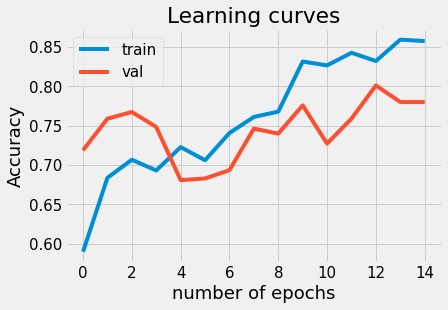

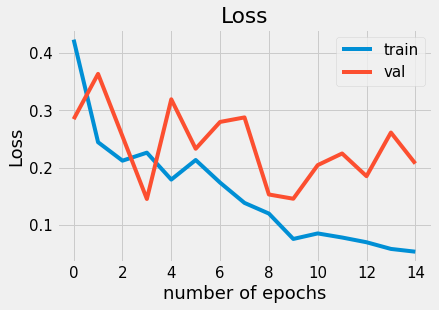

In [23]:
"""EfficientNet B2 Classifier"""

effnet_b2_classifier = effnetb2(pretrained=False)
effnet_b2_classifier = effnet_b2_classifier.to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(effnet_b2_classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

effnet_b2_classifier = train_model(effnet_b2_classifier, criterion, optimizer, scheduler, num_epochs=15)


In [24]:
test(effnet_b2_classifier)

Accuracy of the model based on the test set is: 72 %
